In [1]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle

import xgboost as xgb

from sklearn_pandas import DataFrameMapper

from scipy.sparse import csr_matrix

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords

from stop_words import get_stop_words

import unicodedata
import string

import io
import math
import requests

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_columns', 200)

# Helper fuctions and classes

In [2]:
def get_xgb_prediction(number_round, params, train_df, test_df, target_df):
    d_train = xgb.DMatrix(csr_matrix(train_df), label=target_df)
    d_test = xgb.DMatrix(csr_matrix(test_df))
    print('training')
    classifier = xgb.train(params, d_train, number_round)
    print('predicting')
    preds = classifier.predict(d_test, ntree_limit=number_round if params['booster'] == 'dart' else 0)
    return classifier, preds


comma_tokenizer=lambda s: s.split(',')
space_tokenizer=lambda s: s.split()
undescore_tokenizer=lambda s: s.split('_')
dot_tokenizer=lambda s: s.split('.')


class GetCounter(TransformerMixin, BaseEstimator):
    def __init__(self, field, by_field):
        self.field = field
        self.by_field = by_field
        self.count_map = None

    def fit(self, X):
        assert self.field in X.columns and self.by_field in X.columns
        tmp = X[[self.by_field, self.field]].copy()
        tmp[self.field].fillna('xxx', inplace=True)
        self.count_map = tmp.groupby([self.by_field])\
            .count()[[self.field]]\
            .rename(columns={self.field: 'count_of_' + self.field + '_by_' + str(self.by_field)})
        return self

    def transform(self, X, y=None):
        return X[[self.by_field]]\
            .merge(self.count_map, left_on=self.by_field, right_index=True, how='left')\
            .drop(columns=[self.by_field])


class GetDistinctCounter(TransformerMixin, BaseEstimator):
    def __init__(self, field, by_field):
        self.field = field
        self.by_field = by_field
        self.count_map = None

    def fit(self, X):
        assert self.field in X.columns and self.by_field in X.columns
        tmp = X[[self.by_field, self.field]].copy()
        tmp[self.field].fillna('xxx', inplace=True)
        tmp = tmp.drop_duplicates()
        self.count_map = tmp.groupby([self.by_field])\
            .count()[[self.field]]\
            .rename(columns={self.field: 'distinct_count_of_' + self.field + '_by_' + str(self.by_field)})
        return self

    def transform(self, X, y=None):
        return X[[self.by_field]]\
            .merge(self.count_map, left_on=self.by_field, right_index=True, how='left')\
            .drop(columns=[self.by_field])


class UrlImageSplitter(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.str.split('/', expand=True).iloc[:, 5:].rename(columns='url_image_{}'.format)


class LengthExtractor(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.str.len()


class StrCast(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.astype(str)


class Product(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):

        return X.product(axis=1)


def rm_accent(input_str):
    return unicodedata.normalize('NFKD', input_str.decode('utf8', 'ignore'))\
        .encode('ASCII', 'ignore')\
        .replace('\n', ' ')\
        .translate(None, string.punctuation)


class Formatter(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.apply(rm_accent)


class Stemmer(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        ss = SnowballStemmer('french', ignore_stopwords=True)
        return X.apply(nltk.word_tokenize, language='french')\
            .apply(lambda tokens: " ".join(ss.stem(token) for token in tokens))


class NaFiller(BaseEstimator, TransformerMixin):

    def __init__(self, kind=None):
        self.kind = kind
        self.to_fill = None

    def fit(self, x, y=None):
        if isinstance(self.kind, (int, float)):
            self.to_fill = self.kind
        elif self.kind == 'top':
            self.to_fill = x.describe().top
        elif self.kind == 'mean':
            self.to_fill = x.mean()
        elif self.kind == 'max':
            self.to_fill = x.max()
        elif self.kind == 'median':
            self.to_fill = x.median()
        elif self.kind is None:
            self.to_fill = 'unknown'
        else:
            self.to_fill = self.kind
        return self

    def transform(self, x):
        return x.fillna(self.to_fill)


class LogTransformer(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return np.log(X+1)


class Reshaper(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.reshape(-1, 1)


class Densifier(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.todense()


class Lowerizer(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.str.lower()


class Splitter(TransformerMixin, BaseEstimator):
    def __init__(self,separator=None): self.separator=separator

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.str.split(self.separator)


class LengthCounter(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return X.str.len()


class ContentChecker(TransformerMixin, BaseEstimator):
    def __init__(self,*elts):
        self.elts = elts

    def fit(self, X, y=None): return self

    def transform(self, X):
        return (pd.concat([X.str.contains(i) for i in self.elts], axis=1).any(1) * X)\
            .replace(r'^\s*$', np.nan, regex=True)


class NumericChecker(TransformerMixin, BaseEstimator):
    def __init__(self, *elts):
        self.elts = elts

    def fit(self, X, y=None): return self

    def transform(self, X):
        return X.str.isnumeric() * X


class SizeMapper(BaseEstimator, TransformerMixin):
    def __init__(self, **sml_map):
        self.sml_map = sml_map

    def fit(self, X, y=None): return self

    def transform(self, X):
        return X.replace(self.sml_map)


class NumericCast(TransformerMixin, BaseEstimator):
    def __init__(self): pass

    def fit(self, X): return self

    def transform(self, X, y=None):
        return pd.to_numeric(X)


def cv_combination(row, xgb_params_, d_train_,
                   num_boost_round=100000,
                   n_folds_=5,
                   early_stopping_rounds=200,
                   verbose_eval=100,
                   seed=0,
                   metrics='mlogloss'):
    param_names = row.index.difference(['mlogloss', 'nb_rounds'])
    params_dict = row.loc[param_names].to_dict()
    print "CV with {}".format(", ".join("{k}={v}".format(k=k, v=v) for k, v in params_dict.iteritems()))
    xgb_params_.update(params_dict)
    cv_results = xgb.cv(
        xgb_params_,
        d_train_,
        num_boost_round=num_boost_round,
        nfold=n_folds_,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=verbose_eval,
        show_stdv=True,
        seed=seed,
        metrics=metrics,
    )
    mean_mlogloss = cv_results['test-mlogloss-mean'].min()
    boost_rounds = cv_results['test-mlogloss-mean'].idxmin()
    print("\tlogloss {} for {} rounds".format(mean_mlogloss, boost_rounds))
    print '-'*100
    return pd.Series([mean_mlogloss, boost_rounds])


def cv_tune(train_data, train_target, xgb_params_,
            tune_params_,
            num_boost_round=100000,
            n_folds_=5,
            early_stopping_rounds=200,
            verbose_eval=100,
            seed=0,
            metrics='mlogloss'):
    print "="*120
    tuning_df = shuffle(pd.DataFrame(
        index=pd.MultiIndex.from_product(tune_params_.values(), names=tune_params_.keys()),
        columns=['mlogloss', 'nb_rounds']
    ).reset_index())
    d_train = xgb.DMatrix(csr_matrix(train_data), label=train_target)
    tuning_df.loc[:, ['mlogloss', 'nb_rounds']] = tuning_df.apply(
        cv_combination,
        xgb_params_=xgb_params_,
        d_train_=d_train,
        num_boost_round=num_boost_round,
        n_folds_=n_folds_,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=verbose_eval,
        seed=seed,
        metrics=metrics,
        axis=1).values
    best_iteration = tuning_df.loc[[tuning_df.mlogloss.idxmin()]]
    best_params_ = best_iteration.drop(columns=['mlogloss', 'nb_rounds']).iloc[0].to_dict()
    nb_rounds = best_iteration.iloc[0]['nb_rounds']
    return nb_rounds, best_params_


# Ne fonctionne qu'en Python2, voir commentaire ci-dessous pour Python3
def submit_prediction(df, token, sep=',', **kwargs):
    # TOKEN a recuperer sur la plateforme: "Submissions" > "Submit from your Python Notebook"
    TOKEN = token  # https://qscore.meilleurdatascientistdefrance.com/competitions/
    URL = 'https://qscore.meilleurdatascientistdefrance.com/api/submissions'
    buffer_ = io.BytesIO()  # Python 2
    #     buffer = io.StringIO() # Python 3
    df.to_csv(buffer_, sep=sep, **kwargs)
    buffer_.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)}, files={'datafile': buffer})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'
                        .format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

# Load data

In [3]:
train = pd.read_csv("data/X_train.csv", index_col=0, error_bad_lines=False)
test = pd.read_csv("data/X_test.csv", index_col=0, error_bad_lines=False)
target = pd.read_csv("data/y_train.csv", index_col=0)

n_folds = 5
my_seed = 0

target = target['delai_vente']
train_index = train.index

train_test = pd.concat((train, test), axis=0).reset_index(drop=True)

# create french stop-words list
stop_words = list(get_stop_words('fr'))
nltk_words = list(stopwords.words('french'))
stop_words.extend(nltk_words)

# Feature Engineering

In [4]:
def create_and_fit_mapper(data, tfidf_params_, label_encoded_columns_, numeric_columns_):

    mapper_ = DataFrameMapper(
        [
            (['nom_magasin', 'nom_produit'],
             [GetCounter("nom_produit", 'nom_magasin')],
             {'alias': 'count_nom_produit_by_nom_magasin'},),

            (['nom_magasin', 'nom_produit'],
             [GetDistinctCounter("nom_produit", 'nom_magasin')],
             {'alias': 'distinct_count_nom_produit_by_nom_magasin'},),

            ('sous_categorie_1', [
                StrCast(),
                TfidfVectorizer(tokenizer=comma_tokenizer, **tfidf_params_),
            ],),

            ('sous_categorie_2', [
                StrCast(),
                TfidfVectorizer(**tfidf_params_),
            ],),

            ('description_produit', [
                StrCast(), Formatter(), Stemmer(),
                TfidfVectorizer(**tfidf_params_),
            ],),
        ] + [
            (colname,
             [StrCast(), LabelEncoder()])
            for colname in label_encoded_columns_
        ] + [
            (colname,
             NaFiller(-999))
            for colname in numeric_columns_
        ],
        df_out=True,
        input_df=True
    )

    featurized_ = mapper_.fit_transform(data)

    return mapper_, featurized_

In [5]:
label_encoded_columns = [
    'url_image', 'taille', 'matiere', 'age', 'garantie', 'couleur', 'wifi', 'etat', 'vintage',
    'marque', 'auteur', 'editions', 'categorie', 'sous_categorie_3', 'sous_categorie_4',
    'nom_produit', 'nom_magasin']

numeric_columns = ['annee', 'hauteur_produit', 'largeur_image',
                   'largeur_produit', 'longueur_image', 'longueur_produit',
                   'nb_images', 'poids', 'pointure', 'prix']

tfidf_params = dict(analyzer='word',
                    ngram_range=(1, 3),
                    stop_words=stop_words,
                    lowercase=True,
                    max_features=50,
                    binary=True,
                    norm=None,
                    use_idf=False,
                    strip_accents='ascii',
                    )
mapper, featurized = create_and_fit_mapper(train_test, tfidf_params, label_encoded_columns, numeric_columns)

# Hyperparameters tuning

In [6]:
featurized_train = featurized.loc[train_index]
featurized_test = featurized.loc[featurized.index.difference(train_index)]
featurized_train.shape,featurized_test.shape,

((8880, 179), (2960, 179))

In [7]:
# working on a sample : uncomment for a quick run of the code with poor results
featurized_train = featurized_train.sample(1000)
target = target.loc[featurized_train.index]

In [8]:
xgb_params = {
    'nthread': 16,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'silent': 1,
    'learning_rate': 0.1,
    'lambda': 1,
    'alpha': 1,
}

In [9]:
tune_params = {
    "min_child_weight": [4],  # range(1,12),
    "max_depth": [11],  # range(1,15),
}
best_round, best_params = cv_tune(featurized_train, target, xgb_params, tune_params)

CV with max_depth=11, min_child_weight=4
[0]	train-mlogloss:1.05745+0.00103819	test-mlogloss:1.0871+0.00368673
[100]	train-mlogloss:0.218336+0.00150271	test-mlogloss:1.13034+0.0362067
[200]	train-mlogloss:0.1402+0.00107832	test-mlogloss:1.20232+0.047873
	logloss 1.0381768 for 18 rounds
----------------------------------------------------------------------------------------------------
CV with max_depth=11, min_child_weight=4
[0]	train-mlogloss:1.05745+0.00103819	test-mlogloss:1.0871+0.00368673
[100]	train-mlogloss:0.218336+0.00150271	test-mlogloss:1.13034+0.0362067
[200]	train-mlogloss:0.1402+0.00107832	test-mlogloss:1.20232+0.047873
	logloss 1.0381768 for 18 rounds
----------------------------------------------------------------------------------------------------


In [10]:
xgb_params.update(best_params)

In [11]:
tune_params = {
    "subsample": [1.0],  # np.linspace(.1,1,10),
    "colsample_bytree": [0.4],  # np.linspace(.1,1,10),
}
best_round, best_params = cv_tune(featurized_train, target, xgb_params, tune_params)

CV with subsample=1.0, colsample_bytree=0.4
[0]	train-mlogloss:1.0692+0.00227132	test-mlogloss:1.09005+0.0011682
[100]	train-mlogloss:0.280227+0.00162064	test-mlogloss:1.04754+0.0301449
[200]	train-mlogloss:0.176879+0.00129491	test-mlogloss:1.10933+0.0333335
	logloss 1.0067214 for 34 rounds
----------------------------------------------------------------------------------------------------
CV with subsample=1.0, colsample_bytree=0.4
[0]	train-mlogloss:1.0692+0.00227132	test-mlogloss:1.09005+0.0011682
[100]	train-mlogloss:0.280227+0.00162064	test-mlogloss:1.04754+0.0301449
[200]	train-mlogloss:0.176879+0.00129491	test-mlogloss:1.10933+0.0333335
	logloss 1.0067214 for 34 rounds
----------------------------------------------------------------------------------------------------


In [12]:
xgb_params.update(best_params)
xgb_params

{'alpha': 1,
 'colsample_bytree': 0.4,
 'eval_metric': 'mlogloss',
 'lambda': 1,
 'learning_rate': 0.1,
 'max_depth': 11,
 'min_child_weight': 4,
 'nthread': 16,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 1.0}

In [13]:
tune_params = {
    'booster': ["dart"],
    'sample_type': ["weighted"],  # ['weighted','uniform'],
    'normalize_type': ['forest'],  # ['forest','tree'],
    'rate_drop': [0.05],  # np.linspace(0,.9,10),
    'one_drop': [1],  # [0,1],
    'skip_drop': [.1],  # np.linspace(0,1,11)
}
best_round, best_params = cv_tune(featurized_train, target, xgb_params, tune_params, verbose_eval=100)

CV with one_drop=1, normalize_type=forest, sample_type=weighted, rate_drop=0.05, skip_drop=0.1, booster=dart
[0]	train-mlogloss:1.07539+0.00106226	test-mlogloss:1.08898+0.00302693
[100]	train-mlogloss:0.308638+0.00857189	test-mlogloss:1.03411+0.0258856
[200]	train-mlogloss:0.222316+0.00199767	test-mlogloss:1.0783+0.0307771
	logloss 1.0051554 for 33 rounds
----------------------------------------------------------------------------------------------------
CV with one_drop=1, normalize_type=forest, sample_type=weighted, rate_drop=0.05, skip_drop=0.1, booster=dart
[0]	train-mlogloss:1.07539+0.00106226	test-mlogloss:1.08898+0.00302693
[100]	train-mlogloss:0.308638+0.00857189	test-mlogloss:1.03411+0.0258856
[200]	train-mlogloss:0.222316+0.00199767	test-mlogloss:1.0783+0.0307771
	logloss 1.0051554 for 33 rounds
----------------------------------------------------------------------------------------------------


In [14]:
tune_params = {
    'booster': "dart",
    'sample_type': "weighted",  # ['weighted','uniform'],
    'normalize_type': 'forest',  # ['forest','tree'],
    'rate_drop': 0.1,  # np.linspace(0,.9,10),
    'one_drop': 1,  # [0,1],
    'skip_drop': .33,  # np.linspace(0,1,11),
}
xgb_params.update(tune_params)

# train, predict and make submission

In [15]:
xgb_params.update({'learning_rate': 0.01})

In [16]:
clf, predictions = get_xgb_prediction(best_round, xgb_params, featurized_train, featurized_test, target)
df_submission = pd.DataFrame(predictions, index=test.index)
df_submission.to_csv("xgb.csv", index_label="id", header=['0', '1', '2'])

training
predicting


In [17]:
# uncomment to make a submission
# grab your token here: "https://qscore.meilleurdatascientistdefrance.com/competitions/"
# submit_prediction(df_submission, token, sep=',', index=True)

# plot feature importance

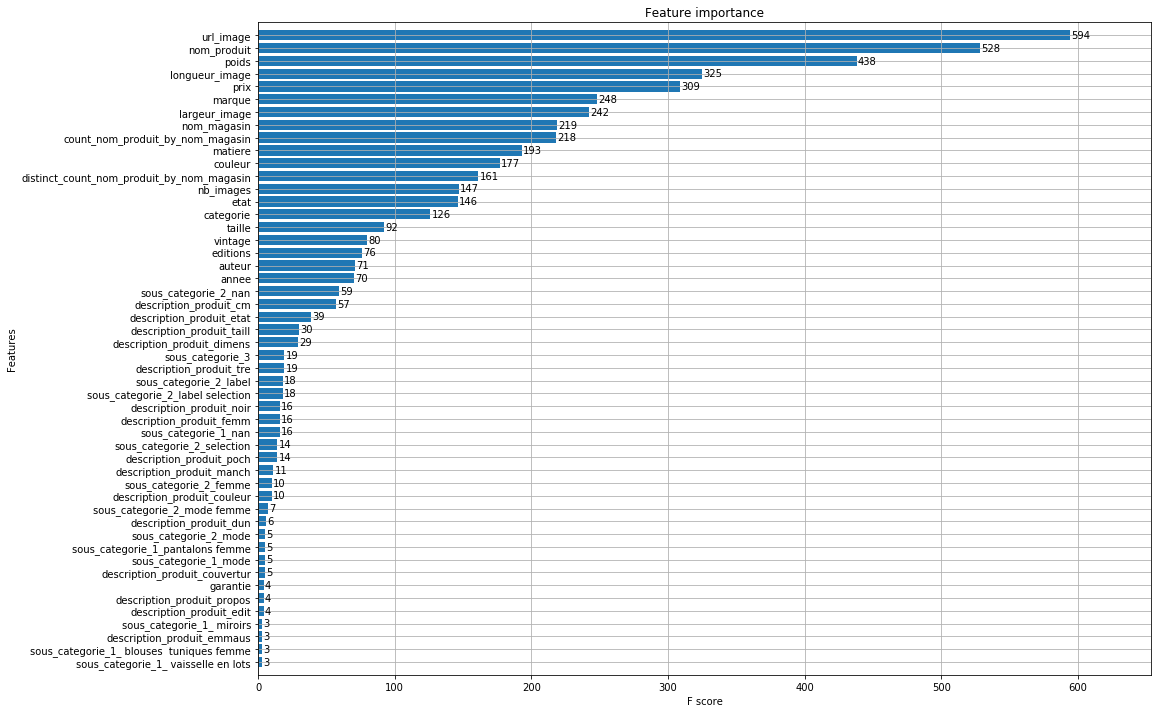

In [18]:
def plot_xgb_importance(number_round, params, train_df, target_df):
    d_train = xgb.DMatrix(csr_matrix(train_df), label=target_df, feature_names=train_df.columns.values)
    clf_ = xgb.train(params, d_train, number_round)
    fig, ax = plt.subplots(figsize=(16, 12))
    xgb.plot_importance(clf_, max_num_features=50, height=0.8, ax=ax)
    plt.show()


plot_xgb_importance(
    best_round,
    xgb_params,
    featurized_train,
    target)